# CMSC 197 Machine Problem 3: Naive Bayes Spam Filter

Author: Chester Ken Gallego

Date: October 8, 2024

Link to the github repository: https://github.com/chstrkn/CMSC197

## Method of Implementation

**Preprocessing**

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import email
import codecs
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [6]:
# Initialize the main dataframe
df = pd.DataFrame(columns = ['folder', 'file', 'email_message', 'classification'])

# Initialize the labels dataframe
labels_path = "trec06p-cs280/labels"
df_labels = pd.read_csv(labels_path, sep=" ", header=None)

# Define columns for the labels dataframe
df_labels.columns = ["classification", "filepath"]

# Convert 'ham' to 0 and 'spam' to 1
df_labels["classification"] = df_labels["classification"].apply(lambda kv: 0 if kv == "ham" else 1)

# Remove "../data/" from the filepath
df_labels["filepath"] = df_labels["filepath"].apply(lambda kv: kv.replace("../data/", ""))
df_labels

,classification,filepath
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [7]:
# List the folders in the data directory
folder_path = "trec06p-cs280/data"
folders = os.listdir(folder_path)
folders

['000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',


In [8]:
# Get stop words
stop_words = []
with open('stop_words.txt', 'r') as file:
    stop_words_list = file.read().splitlines()
    stop_words = [word for word in stop_words_list]
stop_words

['a',
 'able',
 'about',
 'above',
 'abst',
 'accordance',
 'according',
 'accordingly',
 'across',
 'act',
 'actually',
 'added',
 'adj',
 'adopted',
 'affected',
 'affecting',
 'affects',
 'after',
 'afterwards',
 'again',
 'against',
 'ah',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'announce',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apparently',
 'approximately',
 'are',
 'aren',
 'arent',
 'arise',
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'at',
 'auth',
 'available',
 'away',
 'awfully',
 'b',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'begin',
 'beginning',
 'beginnings',
 'begins',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'biol',
 'both',
 'brief',
 'briefly',
 'but',
 'by',
 'c',
 'ca',
 'came',


In [9]:
# Function to drop useless information from the email
def drop_info(msg):
    # Convert the message to lowercase
    msg = msg.lower()
    # Remove all characters except letters and spaces
    msg = re.sub(r'[^a-zA-Z\s]', '', msg)
    # Split the message into a list of words
    words = msg.split()
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    # Join the words back into a single message
    msg = " ".join(words)
    msg = msg.strip("'")
    return msg

# Function to extract the message from a parsed email
def get_msg(parsed):
    msg = ""
    # Iterate over the parts of the email if it is a multipart email
    if parsed.is_multipart():
        for part in parsed.walk():
            if part.get_content_type() == 'text/plain':
                msg = part.get_payload()
                break
    else:
        msg = parsed.get_payload()
    return msg

In [10]:
# Read each email and store them in the main dataframe
for folder in folders:
    # Get the files inside the folder
    files = os.listdir(f"{folder_path}/{folder}")
    for file in files:
        # Open the email file, preprocessed in the standard character set ISO-8859-1
        with open(f"{folder_path}/{folder}/{file}", "r", encoding="ISO-8859-1") as e_mail:
            read_email = e_mail.read()
            parsed_email = email.message_from_string(read_email)
            msg = get_msg(parsed_email)
            msg = drop_info(msg)
            # Get the classification of the email based on the labels dataframe
            labels_classification = df_labels[df_labels['filepath'] == f"{folder}/{file}"]['classification'].values[0]
            # Concatenate the data into the main dataframe
            df = pd.concat([df, pd.DataFrame([[folder, file, msg, labels_classification]], columns=["folder", "file", "email_message", "classification"])], ignore_index=True)
df

,folder,file,email_message,classification
0,000,000,mailing list queried weeks ago running set arc...,0
1,000,001,luxury watches buy rolex rolex cartier bvlgari...,1
2,000,002,academic qualifications prestigious nonacc red...,1
3,000,003,greetings verify subscription planfans list ch...,0
4,000,004,chauncey conferred luscious continued tonsillitis,1
...,...,...,...,...
37817,126,017,great news expec ted infinex ventures infx pri...,1
37818,126,018,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,019,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,020,prosperous future increased money earning powe...,1


In [11]:
# Save the preprocessed emails to a CSV file
df.to_csv("preprocessed_emails.csv", index=False)

# Read the preprocessed emails from the CSV file
df2 = pd.read_csv("preprocessed_emails.csv")

# Split the dataset into training and testing sets
# Folders 0-70: Training Set
training_df = df2[df2['folder'] < 71]
# Folders 71-126: Testing Set
testing_df = df2[df2['folder'] >= 71]

# Classify training set into ham and spam
training_ham_df = training_df[training_df['classification'] == 0]
training_spam_df = training_df[training_df['classification'] == 1]

df2

,folder,file,email_message,classification
0,0,0,mailing list queried weeks ago running set arc...,0
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
3,0,3,greetings verify subscription planfans list ch...,0
4,0,4,chauncey conferred luscious continued tonsillitis,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,prosperous future increased money earning powe...,1


In [12]:
training_ham_df

,folder,file,email_message,classification
0,0,0,mailing list queried weeks ago running set arc...,0
3,0,3,greetings verify subscription planfans list ch...,0
5,0,5,quiet quiet well straw poll plan running,0
6,0,6,working departed totally bell labs recommended...,0
10,0,10,greetings mass acknowledgement signed planfans...,0
...,...,...,...,...
21270,70,270,equation generate prime numbers equation theor...,0
21271,70,271,equation generate prime numbers equation theor...,0
21288,70,288,dear dmdx users guidance generating dmdx item ...,0
21293,70,293,built handyboard works great testmotor passes ...,0


In [13]:
training_spam_df

,folder,file,email_message,classification
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
4,0,4,chauncey conferred luscious continued tonsillitis,1
7,0,7,nbc today body diet beaches magazines hollywoo...,1
8,0,8,oil sector going crazy weekly gift kkpt thing ...,1
...,...,...,...,...
21294,70,294,txtadd,1
21295,70,295,btijclnab binpqnejgmb httpgethighbizez bldb xi...,1
21296,70,296,special offer adobe video collection adobe pre...,1
21297,70,297,doctype html public wcdtd html transitionalen ...,1


In [14]:
testing_df

,folder,file,email_message,classification
21300,71,0,hesitantly derive perverse satisfaction clodho...,1
21301,71,1,things perform experiment display will remain ...,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1
21304,71,4,special offer adobe video collection adobe pre...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,prosperous future increased money earning powe...,1


In [15]:
# Dictionary where the key is the word and the value is the word count
word_count = {}

for index, row in training_df.iterrows():
    for word in str(row['email_message']).split():
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

# Sort the dictionary by value in descending order
sorted_word_count = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)

# Extract the 10,000 most common words
most_common_words = dict(sorted_word_count[:10000])
most_common_words

{'bb': 16763,
 'td': 12700,
 'will': 11322,
 'tr': 10017,
 'br': 5751,
 'width': 5392,
 'board': 5171,
 'company': 4403,
 'price': 4391,
 'email': 4051,
 'list': 3935,
 'gold': 3922,
 'nil': 3830,
 'time': 3816,
 'help': 3779,
 'send': 3650,
 'message': 3589,
 'dont': 3571,
 'subject': 3567,
 'size': 3541,
 'adobe': 3490,
 'crustl': 3295,
 'body': 3259,
 'received': 3091,
 'program': 3081,
 'html': 3076,
 'work': 2778,
 'wrote': 2670,
 'ms': 2664,
 'well': 2647,
 'professional': 2628,
 'border': 2516,
 'good': 2476,
 'number': 2469,
 'university': 2437,
 'widthfont': 2414,
 'problem': 2360,
 'table': 2300,
 'widthtd': 2294,
 'file': 2245,
 'stock': 2243,
 'handyboard': 2231,
 'hb': 2202,
 'font': 2199,
 'color': 2198,
 'bit': 2191,
 'office': 2161,
 'de': 2160,
 'info': 2131,
 'windows': 2094,
 'add': 2062,
 'microsoft': 2060,
 'current': 2054,
 'studies': 2004,
 'contenttype': 1973,
 'news': 1968,
 'code': 1955,
 'development': 1935,
 'corp': 1930,
 'pro': 1926,
 'find': 1923,
 'china

**Creating the feature matrices**

In [17]:
# Feature matrix for the spam training set
feature_matrix_spam = np.zeros((len(training_spam_df), 10000))
list_most_common_words = list(most_common_words.keys())

for index in range(len(training_spam_df)):
    for word in str(training_spam_df.iloc[index]['email_message']).split():
        if word in most_common_words:
            feature_matrix_spam[index][list_most_common_words.index(word)] = 1

feature_matrix_spam

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
# Feature matrix for the ham training set
feature_matrix_ham = np.zeros((len(training_ham_df), 10000))

for index in range(len(training_ham_df)):
    for word in str(training_ham_df.iloc[index]['email_message']).split():
        if word in most_common_words:
            feature_matrix_ham[index][list_most_common_words.index(word)] = 1

feature_matrix_ham

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Computing the Priors**

In [20]:
# Compute the probabilities for spam and ham

# Number of ham emails in the training set
n_ham = len(training_ham_df)
# Number of spam emails in the training set
n_spam = len(training_spam_df)
# Total number of emails
n_doc = len(training_df)

# Formulas
p_ham = n_ham / n_doc
p_spam = n_spam / n_doc

# Print the probabilities of ham and spam
print(f"P(c = ham) = {p_ham}")
print(f"P(c = spam) = {p_spam}")

P(c = ham) = 0.3531924882629108
P(c = spam) = 0.6468075117370892


**Computing the Likelihood of each word**

In [22]:
def laplace_smoothing(feature_matrix_spam, feature_matrix_ham, smoothing_param = 1.0):
    # Initialize the probability of each word given spam and ham
    word_probabilities_spam = np.zeros(len(most_common_words))
    word_probabilities_ham = np.zeros(len(most_common_words))
    
    # Count occurrences of words in spam and ham emails
    word_count_spam = np.sum(feature_matrix_spam, axis=0)
    word_count_ham = np.sum(feature_matrix_ham, axis=0)
    
    # Total number of words in spam and ham
    total_words_spam = np.sum(word_count_spam)
    total_words_ham = np.sum(word_count_ham)
    
    # Initialize the number of classes
    num_classes = 2

    # Calculate the likelihood of each word with Laplace smoothing
    for i in range(len(most_common_words)):
        word_probabilities_spam[i] = (word_count_spam[i] + smoothing_param) / (total_words_spam + smoothing_param * num_classes)
        word_probabilities_ham[i] = (word_count_ham[i] + smoothing_param) / (total_words_ham + smoothing_param * num_classes)

    return word_probabilities_spam, word_probabilities_ham

# Calculate the likelihood of words given spam and ham using Laplace smoothing
likelihood_spam, likelihood_ham = laplace_smoothing(feature_matrix_spam, feature_matrix_ham)

# Print the likelihood of each word given spam and ham after applying Laplace smoothing
print("Likelihood of each word given spam (after applying Laplace smoothing):")
print(likelihood_spam)
print("Likelihood of each word given ham (after applying Laplace smoothing):")
print(likelihood_ham)

Likelihood of each word given spam (after applying Laplace smoothing):
[2.24136692e-03 1.55638004e-03 4.94313486e-03 ... 4.71630314e-05
 4.71630314e-05 4.71630314e-05]
Likelihood of each word given ham (after applying Laplace smoothing):
[4.97431320e-05 3.86891027e-05 6.36988440e-03 ... 2.76350733e-06
 2.76350733e-06 2.76350733e-06]


**Classifying the emails**

In [24]:
# Function for classifying emails as ham (0) or spam (1)
def classify_email(email, likelihood_ham, likelihood_spam, p_ham, p_spam):
    # Initialize the log probabilities for ham and spam
    log_probability_ham = 0
    log_probability_spam = 0
    
    # Split the email into words
    words = str(email).split()
    
    # Compute the log probabilities for each word in the email
    for word in words:
        if word in most_common_words:
            log_probability_ham += np.log(likelihood_ham[list_most_common_words.index(word)])
            log_probability_spam += np.log(likelihood_spam[list_most_common_words.index(word)])
    
    # Add the log probabilities of the prior probabilities for ham and spam
    log_probability_ham += np.log(p_ham)
    log_probability_spam += np.log(p_spam)
    
    # Return 0 if the email is classified as ham; otherwise, return 1 for spam
    return 0 if log_probability_ham > log_probability_spam else 1

In [25]:
# Classify the training emails and store the results in a new column 'predicted'
training_df_predicted = training_df.copy()
training_df_predicted.loc[:, 'predicted'] = training_df_predicted['email_message'].apply(
    lambda email: classify_email(email, likelihood_ham, likelihood_spam, p_ham, p_spam)
)
training_df_predicted

,folder,file,email_message,classification,predicted
0,0,0,mailing list queried weeks ago running set arc...,0,0
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1,1
2,0,2,academic qualifications prestigious nonacc red...,1,1
3,0,3,greetings verify subscription planfans list ch...,0,0
4,0,4,chauncey conferred luscious continued tonsillitis,1,0
...,...,...,...,...,...
21295,70,295,btijclnab binpqnejgmb httpgethighbizez bldb xi...,1,1
21296,70,296,special offer adobe video collection adobe pre...,1,1
21297,70,297,doctype html public wcdtd html transitionalen ...,1,1
21298,70,298,mounted isu infrared demodulator hb realised r...,0,0


In [26]:
# Count the number of correctly classified emails
correct_count = 0

# Iterate over each email in the training DataFrame
for index, row in training_df_predicted.iterrows():
    # Check if the predicted classification matches the actual classification
    if float(row['classification']) == float(row['predicted']):
        correct_count += 1

# Total number of emails
total_emails = len(training_df_predicted)

# Print the results
print(
    f"Out of {total_emails} emails, {correct_count} were classified correctly. "
    f"This represents an accuracy of {correct_count / total_emails * 100:.2f}%."
)

Out of 21300 emails, 20324 were classified correctly. This represents an accuracy of 95.42%.


**Testing the Classifier**

In [28]:
# Classify the testing emails and store the results in a new column 'predicted'
testing_df_predicted = testing_df.copy()
testing_df_predicted.loc[:, 'predicted'] = testing_df_predicted['email_message'].apply(
    lambda email: classify_email(email, likelihood_ham, likelihood_spam, p_ham, p_spam)
).values
testing_df_predicted

,folder,file,email_message,classification,predicted
21300,71,0,hesitantly derive perverse satisfaction clodho...,1,1
21301,71,1,things perform experiment display will remain ...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,prosperous future increased money earning powe...,1,1


In [29]:
# Count the number of correctly classified emails
correct_count = 0

# Iterate over each email in the training DataFrame
for index, row in testing_df_predicted.iterrows():
    # Check if the predicted classification matches the actual classification
    if float(row['classification']) == float(row['predicted']):
        correct_count += 1

# Total number of emails
total_emails = len(testing_df_predicted)

# Print the results
print(
    f"Out of {total_emails} emails, {correct_count} were classified correctly. "
    f"This represents an accuracy of {correct_count / total_emails * 100:.2f}%."
)

Out of 16522 emails, 15349 were classified correctly. This represents an accuracy of 92.90%.


**Performance Evaluation**

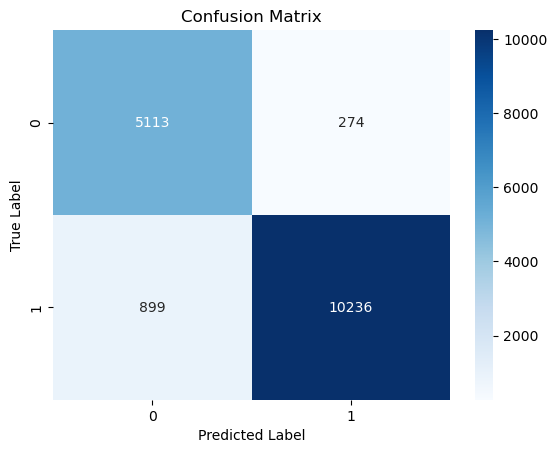

False Positive Count (FP): 274
False Negative Count (FN): 899
True Positive Count (TP): 10236
True Negative Count (TN): 5113


In [31]:
# Extract the actual and predicted classifications
true_labels = np.array(testing_df_predicted['classification'])
predicted_labels = np.array(testing_df_predicted['predicted'])

# Generate the confusion matrix using true and predicted labels
confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Create a heatmap to visualize the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Extract values from the confusion matrix
false_positives = confusion_matrix[0][1]  # Predicted spam but is actually ham
false_negatives = confusion_matrix[1][0]  # Predicted ham but is actually spam
true_positives = confusion_matrix[1][1]   # Correctly predicted spam
true_negatives = confusion_matrix[0][0]   # Correctly predicted ham

# Print the results of the confusion matrix
print(f"False Positive Count (FP): {false_positives}")
print(f"False Negative Count (FN): {false_negatives}")
print(f"True Positive Count (TP): {true_positives}")
print(f"True Negative Count (TN): {true_negatives}")

In [32]:
# Calculate the percentage of correctly identified spam and ham emails
accuracy = accuracy_score(true_labels, predicted_labels)
# Calculate the percentage of actual spam emails that are correctly classified as spam
recall = recall_score(true_labels, predicted_labels)
# Calculate the percentage of emails predicted as spam that are actually spam
precision = precision_score(true_labels, predicted_labels)

# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")

Accuracy: 92.90%
Recall: 91.93%
Precision: 97.39%


## Results and Discussion

1. What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

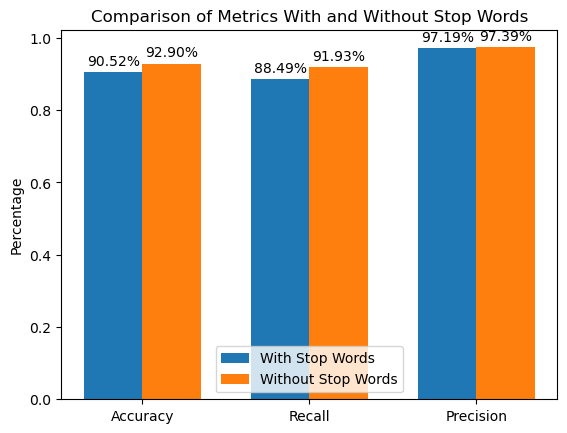

In [35]:
# Store the precision, recall, and accuracy without removing stop words
# These values are obtained by running the code above while commenting out the stop word removal part
accuracy_with_stopwords = 0.9051567606827261
recall_with_stopwords = 0.8848675348001797
precision_with_stopwords = 0.9718879463405011

# Prepare data for plotting
metrics = ['Accuracy', 'Recall', 'Precision']
with_stopwords = [accuracy_with_stopwords, recall_with_stopwords, precision_with_stopwords]
without_stopwords = [accuracy, recall, precision]

# Create the bar plot
x = np.arange(len(metrics))
width = 0.35
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, with_stopwords, width, label='With Stop Words')
bars2 = ax.bar(x + width/2, without_stopwords, width, label='Without Stop Words')
ax.set_ylabel('Percentage')
ax.set_title('Comparison of Metrics With and Without Stop Words')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add value labels on top of the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height * 100:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add value labels on top of the bars
add_value_labels(bars1)
add_value_labels(bars2)

plt.show()

Based on the bar graph above, the accuracy when stop words are not removed is 90.52%, while it is 92.90% when they are removed. Recall is 88.49% when stop words are not removed, compared to 91.93% when they are removed. Precision is 97.19% when stop words are not removed, while it is 97.39% when they are removed. This implies that removing the stop words results in improved model performance across all metrics which indicates a more effective classification of spam and ham emails.

2. Experiment on the number of words used for training. Filter the dictionary to include only words occurring more than k times (1000 words, then k > 100, and k = 50 times). For example, the word "offer" appears 150 times, that means that it will be included in the dictionary.

In [38]:
def filter_words(word_count, k):
    return {word: count for word, count in word_count.items() if count > k}

def create_feature_matrix(df, most_common_words):
    feature_matrix = np.zeros((len(df), len(most_common_words)))
    list_most_common_words = list(most_common_words.keys())
    
    for index in range(len(df)):
        for word in str(df.iloc[index]['email_message']).split():
            if word in most_common_words:
                feature_matrix[index][list_most_common_words.index(word)] = 1
    
    return feature_matrix

def laplace_smoothing2(feature_matrix_spam, feature_matrix_ham):
    # Initialize the probability of each word given spam and ham
    word_probabilities_spam = np.zeros(feature_matrix_spam.shape[1])
    word_probabilities_ham = np.zeros(feature_matrix_ham.shape[1])
    
    # Count occurrences of words in spam and ham emails
    word_count_spam = np.sum(feature_matrix_spam, axis=0)
    word_count_ham = np.sum(feature_matrix_ham, axis=0)
    
    # Total number of words in spam and ham
    total_words_spam = np.sum(word_count_spam)
    total_words_ham = np.sum(word_count_ham)
    
    # Initialize the Laplace smoothing parameter and the number of classes
    smoothing_param = 1
    num_classes = 2

    # Calculate the likelihood of each word with Laplace smoothing
    for i in range(len(word_probabilities_spam)):
        word_probabilities_spam[i] = (word_count_spam[i] + smoothing_param) / (total_words_spam + smoothing_param * num_classes)
        word_probabilities_ham[i] = (word_count_ham[i] + smoothing_param) / (total_words_ham + smoothing_param * num_classes)

    return word_probabilities_spam, word_probabilities_ham

def classify_email2(email, likelihood_ham, likelihood_spam, p_ham, p_spam, most_common_words):
    log_probability_ham = 0
    log_probability_spam = 0
    
    words = str(email).split()
    
    for word in words:
        if word in most_common_words:
            log_probability_ham += np.log(likelihood_ham[list(most_common_words.keys()).index(word)])
            log_probability_spam += np.log(likelihood_spam[list(most_common_words.keys()).index(word)])
    
    log_probability_ham += np.log(p_ham)
    log_probability_spam += np.log(p_spam)
    
    return 0 if log_probability_ham > log_probability_spam else 1

k_values = [1000, 500, 100, 50]
results = {}

for k in k_values:
    filtered_words = filter_words(most_common_words, k)
    
    # Create feature matrices for spam and ham
    feature_matrix_spam2 = create_feature_matrix(training_spam_df, filtered_words)
    feature_matrix_ham2 = create_feature_matrix(training_ham_df, filtered_words)

    # Calculate the likelihood of words using Laplace smoothing
    likelihood_spam, likelihood_ham = laplace_smoothing2(feature_matrix_spam2, feature_matrix_ham2)

    # Classify the testing emails and store the results in a new column 'predicted'
    testing_df = testing_df.copy()
    testing_df.loc[:, 'predicted'] = testing_df['email_message'].apply(
        lambda email: classify_email2(email, likelihood_ham, likelihood_spam, p_ham, p_spam, filtered_words)
    )

    # Extract the actual and predicted classifications
    true_labels = np.array(testing_df['classification'])
    predicted_labels = np.array(testing_df['predicted'])

    # Calculate accuracy, recall, and precision
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)

    # Store results for the current k
    results[k] = {
        'Accuracy': accuracy * 100,
        'Recall': recall * 100,
        'Precision': precision * 100
    }

# Create a DataFrame for the results
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.index.name = 'k Value'
results_df.reset_index(inplace=True)
results_df

,k Value,Accuracy,Recall,Precision
0,1000,90.176734,92.950157,92.509832
1,500,92.204334,93.426134,94.926544
2,100,92.773272,92.303547,96.825247
3,50,92.906428,92.213740,97.115294


Based on the values, it can be concluded that as the number of words in the dictionary is filtered to include only those occurring more than k times, a lower value of k typically results in improved metrics for the model.

3. Discuss the results of the different parameters used for Lambda smoothing. Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate performance metrics for each.

In [41]:
# Function to run classification and evaluate metrics for a given λ
def evaluate_lambda(lmbda):
    likelihood_spam, likelihood_ham = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, lmbda)
    
    testing_df_copy = testing_df.copy()
    testing_df_copy.loc[:, 'predicted'] = testing_df_copy['email_message'].apply(
        lambda email: classify_email(email, likelihood_ham, likelihood_spam, p_ham, p_spam)
    ).values
    
    true_labels = np.array(testing_df_copy['classification'])
    predicted_labels = np.array(testing_df_copy['predicted'])
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    
    return accuracy, recall, precision

# List of λ values to test
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]

# DataFrame to store the results
results_list = []

# Evaluate for each λ
for lmbda in lambda_values:
    accuracy, recall, precision = evaluate_lambda(lmbda)
    results_list.append({
        'Lambda': lmbda,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision
    })

# Convert list of results to DataFrame
results_df = pd.DataFrame(results_list)

# Display the results
results_df

,Lambda,Accuracy,Recall,Precision
0,2.000,0.928338,0.918455,0.973722
1,1.000,0.929004,0.919264,0.973930
2,0.500,0.929851,0.920341,0.974144
3,0.100,0.931727,0.922676,0.974670
4,0.005,0.931667,0.921419,0.975842


Based on the results, it can be concluded that as the value of λ decreases, the performance metrics (accuracy, recall, and precision) show a slight improvement. Although the changes are not drastic, the overall trend suggests that lower values of λ lead to better performance.

4. What are your recommendations to further improve the model?


To further improve the model, it is recommended to remove HTML tags such as `<td>`, `<tr>`, and `<br>` because they are included in the top five most common words, even though they are not particularly useful.